In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import json

from warnings import filterwarnings
sns.set(style='darkgrid')
filterwarnings('ignore')

## Загрузка данных.

Загрузим имеющуюся таблицу с коэффициентами на линию "Индивидуальный тотал" на матчи РПЛ за 2020/21-2024/25 сезоны

In [8]:
clubs_mapper = {
    'Локомотив Москва': 'Lokomotiv Moscow',
    'ФК Ростов': 'Rostov',
    'Динамо Москва': 'Dinamo Moscow',
    'Ахмат': 'Akhmat Grozny',
    'Крылья Советов': 'Krylia Sovetov',
    'Нижний Новгород': 'Nizhny Novgorod',
    'Химки': 'FC Khimki',
    'ФК Оренбург': 'Orenburg',
    'Рубин': 'Rubin Kazan',
    'Факел': 'Fakel Voronezh',
    'Акрон Тольятти': 'Akron',
    'Динамо Махачкала': 'Dynamo Makhachkala',
    'Зенит': 'Zenit St Petersburg',
    'ФК Краснодар': 'FK Krasnodar',
    'Спартак Москва': 'Spartak Moscow',
    'ЦСКА Москва': 'CSKA Moscow',
    'Балтика': 'Baltika Kaliningrad',
    'Урал': 'Ural',
    'ФК Сочи': 'Sochi',
    'Спартак': 'Spartak Moscow',
    'Пари Нижний Новгород': 'Nizhny Novgorod',
    'Краснодар': 'FK Krasnodar',
    'Сочи': 'Sochi',
    'Факел Воронеж': 'Fakel Voronezh',
    'ЦСКА': 'CSKA Moscow',
    'Локомотив': 'Lokomotiv Moscow',
    'Оренбург': 'Orenburg',
    'Ростов': 'Rostov',
    'Торпедо': 'Torpedo Moscow',
    'Арсенал Тула': 'Arsenal Tula',
    'Уфа': 'Ufa',
    'Ротор': 'Rotor Volgograd',
    'Тамбов': 'Tambov'
}
cols_mapper = {
    'ИТБ 1 (0,5)': 'total_over_0_5',
    'ИТБ 1 (1)': 'total_over_1',
    'ИТБ 1 (1.5)': 'total_over_1_5',
    'ИТБ 1 (2)': 'total_over_2',
    'ИТБ 1 (2.5)': 'total_over_2_5',
    'ИТБ 1 (3)': 'total_over_3',
    'ИТБ 1 (3.5)': 'total_over_3_5',
    'ИТБ 1 (4)': 'total_over_4'
}
coefs = pd.read_excel('coefficients.xlsx').iloc[1:]
coefs['Date'] = coefs['Date'].map(lambda x: pd.to_datetime(str(x)[:10]))
coefs = coefs[coefs['Date'] >= pd.to_datetime('2020-08-08')].sort_values(by='Date').reset_index().drop(columns='index')
coefs['Team'] = coefs['Team'].map(clubs_mapper)
coefs['Opponent'] = coefs['Opponent'].map(clubs_mapper)
coefs_home = coefs.iloc[:, :11].rename(columns=cols_mapper)
coefs_away = pd.DataFrame()
coefs_away['Date'] = coefs_home['Date']
coefs_away['Team'] = coefs_home['Opponent']
coefs_away['Opponent'] = coefs_home['Team']
coefs_away[['total_over_0_5', 'total_over_1',
       'total_over_1_5', 'total_over_2', 'total_over_2_5', 'total_over_3',
       'total_over_3_5', 'total_over_4']] = coefs[['ИТБ 2 (0,5)', 'ИТБ 2 (1)', 'ИТБ 2 (1.5)',
       'ИТБ 2 (2)', 'ИТБ 2 (2.5)', 'ИТБ 2 (3)', 'ИТБ 2 (3.5)', 'ИТБ 2 (4)']]
coefs_final = pd.concat([coefs_home, coefs_away])
coefs_final.head(5)

,Date,Team,Opponent,total_over_0_5,total_over_1,total_over_1_5,total_over_2,total_over_2_5,total_over_3,total_over_3_5,total_over_4
0,2020-08-08,FC Khimki,CSKA Moscow,1.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-08,Tambov,Rostov,1.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-09,Arsenal Tula,Akhmat Grozny,NaN,NaN,2.50,NaN,NaN,NaN,NaN,NaN
3,2020-08-09,Ufa,FK Krasnodar,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-08-09,Spartak Moscow,Sochi,NaN,NaN,1.76,NaN,NaN,NaN,NaN,NaN


На каждую команду открывается ровно один тотал в линии, поэтому матрица коэффициентов получается разреженной.

In [11]:
for col in ['total_over_0_5', 'total_over_1',
       'total_over_1_5', 'total_over_2', 'total_over_2_5', 'total_over_3',
       'total_over_3_5', 'total_over_4']:
    print(col)
    print('% of nans:', coefs_final[col].isna().sum() / len(coefs_final[col]))
    print()

total_over_0_5
% of nans: 0.719281663516068

total_over_1
% of nans: 0.8653119092627599

total_over_1_5
% of nans: 0.4862948960302457

total_over_2
% of nans: 0.9792060491493384

total_over_2_5
% of nans: 0.9532136105860114

total_over_3
% of nans: 1.0

total_over_3_5
% of nans: 0.9966918714555766

total_over_4
% of nans: 1.0



Видно, что примеров коэффициентов после тотала 1.5 почти нет, поэтому наблюдения, где на команду открывался только тотал 2 или больше, или же информация о коэффициентах вообще недоступна, будем отдельно кодировать дамми-переменной, а хранить будем только коэффициенты на тотал больше 0.5, 1, 1.5.

In [14]:
coefs_final = pd.concat([coefs_home, coefs_away])
coefs_final = coefs_final[['Date', 'Team', 'Opponent', 'total_over_0_5', 'total_over_1', 'total_over_1_5']]
coefs_final = coefs_final.fillna(0)
coefs_final['hash'] = coefs_final.apply(lambda x: len(str(x['Team'])) * len(str(x['Opponent'])) * max(len(str(x['Team'])), \
                                        len(str(x['Opponent']))), axis=1) 
coefs_final = coefs_final.sort_values(by=['Date', 'hash'])
coefs_final = coefs_final.drop(columns='hash')
coefs_final

,Date,Team,Opponent,total_over_0_5,total_over_1,total_over_1_5
1,2020-08-08,Tambov,Rostov,1.46,0.00,0.00
1,2020-08-08,Rostov,Tambov,0.00,0.00,2.16
0,2020-08-08,FC Khimki,CSKA Moscow,1.65,0.00,0.00
0,2020-08-08,CSKA Moscow,FC Khimki,0.00,0.00,2.05
3,2020-08-09,Ufa,FK Krasnodar,1.60,0.00,0.00
...,...,...,...,...,...,...
1053,2025-05-18,Spartak Moscow,Krylia Sovetov,0.00,0.00,2.17
1054,2025-05-18,Akhmat Grozny,Dynamo Makhachkala,0.00,0.00,2.05
1054,2025-05-18,Dynamo Makhachkala,Akhmat Grozny,0.00,1.90,0.00
1057,2025-05-19,Lokomotiv Moscow,CSKA Moscow,0.00,1.68,0.00


Теперь загрузим датасет со всеми матчами РПЛ за сезоны 2020/21-2024/25 и соединим его с имеющимися коэффициентами.

In [17]:
matches = pd.read_csv('results.csv', sep=';').rename(columns={'For': 'scored', 'Against': 'missed'})
matches['target'] = (matches['scored'] > 0).astype(int)
matches['Date'] = matches['Date'].map(lambda x: pd.to_datetime(x))
matches = matches.join(coefs_final.set_index(['Date', 'Team', 'Opponent']), how='left', on=['Date', 'Team', 'Opponent']).fillna(0)
matches = matches.drop_duplicates()
matches['no_coefs'] = (matches['total_over_0_5'] + matches['total_over_1'] + \
                      matches['total_over_1_5'] == 0).astype(int)
# matches = matches[matches['no_coefs'] == 0].drop(columns='no_coefs')
matches

,Date,Team,Opponent,scored,missed,Venue,Result,Season,MD,Result Margin,target,total_over_0_5,total_over_1,total_over_1_5,no_coefs
0,2020-08-08,FC Khimki,CSKA Moscow,0,2,H,L,2020/21,1,-2,0,1.65,0.00,0.00,0
1,2020-08-08,CSKA Moscow,FC Khimki,2,0,A,W,2020/21,1,2,1,0.00,0.00,2.05,0
2,2020-08-08,Tambov,Rostov,0,1,H,L,2020/21,1,-1,0,1.46,0.00,0.00,0
3,2020-08-08,Rostov,Tambov,1,0,A,W,2020/21,1,1,1,0.00,0.00,2.16,0
4,2020-09-08,Ufa,FK Krasnodar,0,3,H,L,2020/21,1,-3,0,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2025-05-18,Spartak Moscow,Krylia Sovetov,2,0,A,W,2024/25,29,2,1,0.00,0.00,2.17,0
2372,2025-05-18,Akhmat Grozny,Dynamo Makhachkala,1,1,H,D,2024/25,29,0,1,0.00,0.00,2.05,0
2373,2025-05-18,Dynamo Makhachkala,Akhmat Grozny,1,1,A,D,2024/25,29,0,1,0.00,1.90,0.00,0
2374,2025-05-19,Lokomotiv Moscow,CSKA Moscow,2,2,H,D,2024/25,29,0,1,0.00,1.68,0.00,0


In [133]:
all_matches[all_matches['Date'] >= pd.to_datetime('2025-01-01')]

,Date,Team,Opponent,scored,missed,Venue,Result,Season,MD,Result Margin,target,total_over_0_5,total_over_1,total_over_1_5,no_coefs
2206,2025-02-28,Dynamo Makhachkala,Lokomotiv Moscow,1,1,H,D,2024/25,19,0,1,0.0,2.23,0.00,0
2207,2025-02-28,Lokomotiv Moscow,Dynamo Makhachkala,1,1,A,D,2024/25,19,0,1,0.0,1.64,0.00,0
2208,2025-01-03,Nizhny Novgorod,Akron,2,1,H,W,2024/25,19,1,1,0.0,0.00,0.00,1
2209,2025-01-03,Akron,Nizhny Novgorod,1,2,A,L,2024/25,19,-1,1,0.0,0.00,0.00,1
2210,2025-01-03,Akhmat Grozny,Rubin Kazan,2,1,H,W,2024/25,19,1,1,0.0,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2025-05-18,Spartak Moscow,Krylia Sovetov,2,0,A,W,2024/25,29,2,1,0.0,0.00,2.17,0
2372,2025-05-18,Akhmat Grozny,Dynamo Makhachkala,1,1,H,D,2024/25,29,0,1,0.0,0.00,2.05,0
2373,2025-05-18,Dynamo Makhachkala,Akhmat Grozny,1,1,A,D,2024/25,29,0,1,0.0,1.90,0.00,0
2374,2025-05-19,Lokomotiv Moscow,CSKA Moscow,2,2,H,D,2024/25,29,0,1,0.0,1.68,0.00,0


Разобъем данные на две части: без второй половины сезона 2024/25 и с ней. На данных без второй половины сезона 2024/25 будем обучать модель и подбирать гиперпараметры для формирования датасета и ставочной стратегии, а на второй половине сезона, пользуясь вторым датасетом, будем тестировать стратегию.

In [20]:
all_matches = matches.copy()
matches = matches[matches['Date'] < pd.to_datetime('2025-01-01')]

In [140]:
matches['target'].value_counts(normalize=True)

target
1    0.724841
0    0.275159
Name: proportion, dtype: float64

## Feature engineering.

Создадим json, в котором для каждого тура в каждом сезоне хранилась бы актуальная турнирная таблица, пользуясь имеющимися результатами матчей.

In [24]:
# result = {'L': 0, 'D': 1, 'W': 3}

# table = {}
# for season in sorted(matches['Season'].unique()):
#     table[season] = {}
    
#     for md in sorted(matches[matches['Season'] == season]['MD'].unique()):
#         table[season][md] = {}
        
#         for team in matches[matches['Season'] == season]['Team'].unique():
#             table[season][md][team] = 0
            
#             if matches[(matches['Season'] == season) & (matches['MD'] == md - 1) & (matches['Team'] == team)].shape[0] > 0:
#                 table[season][md][team] = table[season][md - 1][team] + \
#                     result[matches[(matches['Season'] == season) & (matches['MD'] == md - 1) & (matches['Team'] == team)].iloc[0]['Result']]
            
# table_positions = {}
# for season in table:
#     table_positions[season] = {}
#     for md in table[season]:
#         table_positions[season][str(md)] = {}
#         for team in table[season][md]:
#             table_positions[season][str(md)][team] = pd.Series(table[season][md]).sort_values(ascending=False).rank(ascending=False)[team]

# with open('table_positions.json', "w", encoding="utf-8") as json_file:
#     json.dump(table_positions, json_file, indent=4, ensure_ascii=False)

Теперь определим признаки для каждого наблюдения, по которым мы будем предсказывать целевую переменную: вероятность того, что команда забьёт в матче:

1) Среднее количество забитых голов за последние n_avg матчей командой.
2) Дамми-переменная на то, что команда является топ-клубом (CSKA Moscow, Lokomotiv Moscow, Krasnodar, Spartak Moscow, Zenit St Petersburg, Dinamo Moscow).
3) Дамми-переменная на то, что команда играет дома.
4) Среднее количество пропущенных голов за последние n_avg матчей соперником.
5) Дамми-переменная на то, что соперник является топ-клубом.
6) "Транзитивные" победы: количество команд, которые команда обыграла, из числа тех, что обыгрывали соперника за последние k матчей.
7) Разница позиций: (номер тура / 30) * (текущая позиция соперника - текущая позиция команды) + ((30 - номер тура) / 30) *  (позиция соперника в прошлом сезоне - позиция команды в прошлом сезоне).
8) Последний релевантный результат: количество забитых командой голов в последнем матче с одной из n ближайших по разнице позиций команд к сопернику.
9) Дамми-переменная на вторую половину сезона.
10) Коэффициент на индивидуальный тотал больше 0.5 для команды, 0, если отсутствует.
11) Коэффициент на индивидуальный тотал больше 1 для команды, 0, если отсутствует.
12) Коэффициент на индивидуальный тотал больше 1.5 для команды, 0, если отсутствует.
13) Дамми-переменная на отсутствие коэффициентов.

n_avg, k, n, n_margin (с какого тура в сезоне начинаем обучение, отступ нужен, чтобы появились показатели, которые смотрят на несколько матчей назад) являются гиперпараметрами, и будут подбираться при помощи кросс-валидации

Напишем отдельный класс, который трансформировал бы выборку в полноценный датасет с заданными гиперпараметрами, функции для рассчета признаков реализованы в файле features.py.

In [28]:
from features import avg_missed, avg_scored, avg_target, opponent_avg_missed, opponent_avg_scored, \
                        opponent_avg_target, prev_target, team_status, top_clubs, underdogs, underdog, positions_diff, \
                        last_rel_result, transitive_wins

train_cols = ['avg_scored', 'top_club', 'home_team', 'opponent_avg_missed', 'opponent_top_club', 
              'transitive_wins', 'positions_diff', 'last_rel_result', 'season_second_part', 
              'total_over_0_5', 'total_over_1', 'total_over_1_5', 'no_coefs']

coef_cols = ['total_over_0_5', 'total_over_1', 'total_over_1_5', 'no_coefs']

class MatchesTransformer:
    def __init__(self, **kwargs):
        self.n_avg = kwargs.get('n_avg', 0)
        self.n = kwargs.get('n', 0)
        self.k = kwargs.get('k', 0)
        self.n_margin = kwargs.get('n_margin', 0)

    def fit_transform(self, matches):
        data = matches.copy()

        data['avg_scored'] = data.apply(lambda x: avg_scored(x, matches, self.n_avg), axis=1)
        # data['avg_missed'] = data.apply(lambda x: avg_missed(x, matches, self.n_avg), axis=1)
        # data['avg_target'] = data.apply(lambda x: avg_target(x, matches, self.n_avg), axis=1)
        data['top_club'] = data['Team'].map(lambda x: 1 if x in top_clubs else 0)
        data['home_team'] = (matches['Venue'] == 'H').astype(int)

        # data['opponent_avg_scored'] = data.apply(lambda x: opponent_avg_scored(x, matches, self.n_avg), axis=1)
        data['opponent_avg_missed'] = data.apply(lambda x: opponent_avg_missed(x, matches, self.n_avg), axis=1)
        # data['opponent_avg_target'] = data.apply(lambda x: opponent_avg_target(x, matches, self.n_avg), axis=1)
        data['opponent_top_club'] = data['Opponent'].map(lambda x: 1 if x in top_clubs else 0)

        data['transitive_wins'] = data.apply(lambda x: transitive_wins(x, matches, self.k), axis=1)
        data['last_rel_result'] = data.apply(lambda x: last_rel_result(x, matches, self.n), axis=1)
        data['positions_diff'] = data.apply(positions_diff, axis=1)
        data['prev_target'] = data.apply(lambda x: prev_target(x, matches), axis=1)
        data['no_prev_target'] = data['prev_target'].map(lambda x: 1 if pd.isna(x) else 0)
        data['season_second_part'] = data['MD'].map(lambda x: 1 if x >= 19 else 0)

        return data[data['MD'] >= self.n_margin]

Так как прогнозировать и ставить мы будем на определенной части сезона, где матчи будут идти последовательно, зададим разбиение для кросс-валидации руками. Будем разбивать на 8 фолдов, где каждый фолд - последовательные 11 туров определенного сезона.

Также учитывая спеицифику ставок при подборе оптимальных гиперпараметров хотелось бы максимизировать скор, который сильно штрафовал бы за FP, и ощутимо меньше награждал за TP, при этом на остальные прогнозы вообще не обращая внимания. То есть скор, который послужил бы упрощенной симуляцией ставок на основе модели, в результате чего гиперпараметры подбирались бы с учетом финальной задачи.

Скор для кросс-валидации будет считаться как 0.5 * TP - FP и будет максимизироваться.

Также, учитывая дисбаланс классов 75:25 в пользу положительного, на этапе обучения будем делать oversampling, чтобы избежать завышенных вероятностей положительного исхода, обусловленных данным дисбалансом

In [31]:
def cv_split(data):
    splits = []
    for season in ['2020/21', '2021/22', '2022/23', '2023/24']:
        test = data[(data['Season'] == season) & (data['MD'] >= 6) & (data['MD'] <= 18)]
        train = data[~np.isin(data['Season'] + data['MD'].astype(str) + data['Team'] + data['Opponent'],
                              test['Season'] + test['MD'].astype(str) + test['Team'] + test['Opponent'])]
        splits.append([train, test])
        test = data[(data['Season'] == season) & (data['MD'] >= 19)]
        train = data[~np.isin(data['Season'] + data['MD'].astype(str) + data['Team'] + data['Opponent'],
                              test['Season'] + test['MD'].astype(str) + test['Team'] + test['Opponent'])]
        splits.append([train, test])
    return splits

def custom_score(y_true, y_pred):
    return 0.5 * ((y_true == 1) * (y_pred == 1)).sum() - ((y_true == 0) * (y_pred == 1)).sum()

def cv_score(formula, data):
    splits = cv_split(data)
    scores = []
    for split in splits:
        train = split[0]
        test = split[1]
        train0 = train[train['target'] == 0].sample(train[train['target'] == 1].shape[0], replace=True, random_state=94)
        train1 = train[train['target'] == 1]
        train = pd.concat([train0, train1]).sample(frac=1)
        model = smf.logit(formula, train).fit(disp=0)
        scores.append(custom_score(test['target'], model.predict(test) > 0.5))
    return np.mean(scores)

Запустим подбор гиперпараметров на кросс-валидации и будем логгировать результаты.

In [34]:
# logs = {}
# with open('logs.json', "w", encoding="utf-8") as json_file:
#     json.dump(logs, json_file, indent=4, ensure_ascii=False)

In [169]:
formula = 'target ~ '
for col in train_cols:
    if col == 'target':
        continue
    # if col in to_drop:
    #     continue
    if formula[-2:] != '~ ':
        formula += ' + '
    formula += str(col)

n_avgs = range(2, 5)
ns = range(2, 5)
ks = range(6, 15, 3)

params = []
for n_avg in n_avgs:
    for n in ns:
        for k in ks:
            for n_margin in range(1, n_avg + 2):
                params.append({'n_avg': n_avg, 'n': n, 'k': k, 'n_margin': n_margin})
            
transformer = MatchesTransformer(n_avg = params[0]['n_avg'], n = params[0]['n'], k = params[0]['k'])
data = transformer.fit_transform(matches)

actual_params = params[0]
for p in tqdm(params):
    if p['n_avg'] != actual_params['n_avg']:
        data['avg_scored'] = data.apply(lambda x: avg_scored(x, matches, p['n_avg']), axis=1)
        data['opponent_avg_missed'] = data.apply(lambda x: opponent_avg_missed(x, matches, p['n_avg']), axis=1)
    if p['n'] != actual_params['n']:
        data['last_rel_result'] = data.apply(lambda x: last_rel_result(x, matches, p['n']), axis=1)
    if p['k'] != actual_params['k']:
        data['transitive_wins'] = data.apply(lambda x: transitive_wins(x, matches, p['k']), axis=1)
    data = data.fillna(0)
    data = data[data['MD'] >= p['n_margin']]
    actual_params = p
    with open('logs.json', "r", encoding="utf-8") as json_file:
        logs = json.load(json_file)
    logs[round(cv_score(formula, data), 4)] = p
    with open('logs.json', "w", encoding="utf-8") as json_file:
        json.dump(logs, json_file, indent=4, ensure_ascii=False)

  0%|          | 0/108 [00:00<?, ?it/s]

In [36]:
with open('logs.json', "r", encoding="utf-8") as json_file:
    logs = json.load(json_file)
best_params = logs[max(logs)]
print('best score:', max(logs))
print('best params:', best_params)

best score: 22.5
best params: {'n_avg': 3, 'n': 2, 'k': 6, 'n_margin': 3}


После того, как мы нашли лучшие наборы гиперпараметров, хотелось бы сократить признаковое описание. Так как у нас имеется всего 2000 наблюдений, а признаков уже 13, линейная модель может начать переобучаться и плохо обобщать, хотя нам важнее всего как раз обобщающая способность.

Для этого сохраним 5 лучших комбинаций гиперпараметров, после чего на каждой итерации будем исключать 1 признак и смотреть на то, как меняется скор на кросс-валидации. Признак, дающий наибольший прирост к скору, исключается. Так продолжается пока скор на итерации после исключения каждого из признаков по очереди не станет хуже, чем при оставлении всех оставшихся признаков.

In [39]:
best_params_comb = []
for score in sorted(logs)[-5:]:
    best_params_comb.append(logs[score])
    
train_sets = []
for params in best_params_comb:
    transformer = MatchesTransformer(n_avg = params['n_avg'], n = params['n'], k = params['k'])
    data = transformer.fit_transform(matches)
    data = data.fillna(0)
    data = data[data['MD'] >= params['n_margin']]
    train_sets.append(data)

In [40]:
best_score = float(max(logs))
best_params_index = 0
to_drop = []
while True:
    column_to_drop = ''
    print('iter')
    for column in train_cols:
        if column in to_drop:
            continue
        if column in coef_cols:
            continue
        formula = 'target ~ '
        for col in train_cols:
            if col == column:
                continue
            if col in to_drop:
                continue
            if col == 'target':
                continue
            if formula[-2:] != '~ ':
                formula += ' + '
            formula += str(col)
        score = -1
        best_index = 0
        for i in range(len(train_sets)):
            data = train_sets[i]
            curr_score = cv_score(formula, data)
            if curr_score > score:
                score = curr_score
                best_index = i
        if score > best_score:
            best_score = score
            column_to_drop = column
            best_params_index = best_index
        print(column)
        print(score)
    if column_to_drop == '':
        break
    to_drop.append(column_to_drop)
    if 'prev_target' in to_drop and 'no_prev_target' not in to_drop:
        to_drop.append('no_prev_target')
    print(to_drop)
    print()

to_drop

iter
avg_scored
21.9375
top_club
21.9375
home_team
21.9375
opponent_avg_missed
22.5
opponent_top_club
23.9375
transitive_wins
22.5
positions_diff
22.75
last_rel_result
22.375
season_second_part
23.125
['opponent_top_club']

iter
avg_scored
23.0
top_club
22.5625
home_team
21.1875
opponent_avg_missed
23.5625
transitive_wins
23.5
positions_diff
22.1875
last_rel_result
24.1875
season_second_part
23.5625
['opponent_top_club', 'last_rel_result']

iter
avg_scored
22.5
top_club
22.1875
home_team
21.5
opponent_avg_missed
24.0625
transitive_wins
23.625
positions_diff
22.375
season_second_part
23.625


['opponent_top_club', 'last_rel_result']

In [41]:
best_params_comb[best_params_index]

{'n_avg': 2, 'n': 3, 'k': 12, 'n_margin': 3}

Получаем, что, если выбросить дамми-переменную на то, что соперник является топ-клубом, и последний релевантный результат, скор на кросс-валидации увеличивается на 7.5%.

Посмотрим на оценку получившейся модели на всей имеющейся выборке.

In [44]:
formula = 'target ~ '
for col in train_cols:
    if col in to_drop:
        continue
    if formula[-2:] != '~ ':
        formula += ' + '
    formula += str(col)
data = train_sets[best_params_index]
data0 = data[data['target'] == 0].sample(data[data['target'] == 1].shape[0], replace=True, random_state=94)
data1 = data[data['target'] == 1]
data = pd.concat([data0, data1]).sample(frac=1)
model = smf.logit(formula, data).fit(disp=0)
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 2964
Model:                          Logit   Df Residuals:                     2952
Method:                           MLE   Df Model:                           11
Date:                Sun, 08 Jun 2025   Pseudo R-squ.:                 0.05412
Time:                        17:58:30   Log-Likelihood:                -1943.3
converged:                       True   LL-Null:                       -2054.5
Covariance Type:            nonrobust   LLR p-value:                 1.656e-41
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4024      0.379      1.062      0.288      -0.340       1.145
avg_scored              0.1359      0.045      2.993      0.003       0.047       0.225
top_club        

Проинтерпретируем полученные результаты для коэффициентов значимых на уровне значимости $\alpha = 0.05$:

In [46]:
for param in model.params.index:
    if model.pvalues[param] > 0.05:
        continue
    if param == 'Intercept':
        continue
    if len(data[param].unique()) > 2:
        print(param)
        print(f'p-value: {round(model.pvalues[param], 3)}')
        print('Marginal effect:', round((model.predict(data) * (1 - model.predict(data)) * model.params[param]).mean(), 3))
    else:
        data0 = data.copy()
        data0[param] = 0
        data1 = data.copy()
        data1[param] = 1
        print(param)
        print(f'p-value: {round(model.pvalues[param], 3)}')
        print('Marginal effect:', round((model.predict(data1) - model.predict(data0)).mean(), 3))
    print()

avg_scored
p-value: 0.003
Marginal effect: 0.032

top_club
p-value: 0.0
Marginal effect: 0.094

home_team
p-value: 0.0
Marginal effect: 0.102

positions_diff
p-value: 0.04
Marginal effect: 0.004

total_over_0_5
p-value: 0.001
Marginal effect: -0.185

total_over_1
p-value: 0.002
Marginal effect: -0.131

no_coefs
p-value: 0.002
Marginal effect: -0.235



При прочих равных увеличение среднего количества голов, забитых в последних 2 матчах командой, на 1 увеличивает вероятность того, что команда забьет в матче, на 3.5%.

При прочих равных тот факт, что команда является топ-клубом, увеличивает вероятность того, что команда забьет в матче, на 9.2%.

При прочих равных тот факт, что команда играет дома, увеличивает вероятность того, что команда забьет в матче, на 8.9%.

При прочих равных увеличение позиции команды в таблице на 1 по сравнению с соперником увеличивает вероятность того, что команда забьет в матче, на 0.4%.

## Разработка и тестирование стратегии.

Преобразуем нашу тестовую выборку (вторую половину сезона 2024/25) в соответствии с наилучшими гиперпараметрами.

In [50]:
params = best_params_comb[best_params_index]
transformer = MatchesTransformer(n_avg = params['n_avg'], n = params['n'], k = params['k'])
data = transformer.fit_transform(all_matches)
data = data.fillna(0)
data = data[data['MD'] >= params['n_margin']]
train = data[data['Date'] < pd.to_datetime('2025-01-01')]
test = data[data['Date'] >= pd.to_datetime('2025-01-01')]

Сохраним получившийся датасет для тестирования более сложных моделей в будущем.

In [52]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

Ставка на матч будет происходить по следующему принципу:

Будем ставить лишь на те матчи, на которые открывалась линия "Индивидуальный тотал больше 1". При ставке на данную линию выигрыш рассчитывается следующим образом: 0, если команда не забила в матче, деньги возвращаются, если команда забила ровно 1 гол в матче, деньги * коэффициент, если команда забила более 1 гола.

Из этих матчей будем ставить по 100 рублей на те, для которых предсказанная моделью вероятность того, что команда забьет, больше 0.5, и вероятность * коэффициент > 0.9. На остальные матчи не будем ставить ничего.

In [54]:
def profit(model, test):
    preds = model.predict(test)

    coefs = test['total_over_1']
    scored = test['scored']
    ev = preds * coefs
    to_bet = (ev > 0.9).astype(int) * (preds > 0.5).astype(int)
    investment = to_bet.sum() * 100
    revenue = ((to_bet * scored > 1).astype(int) * coefs * 100).sum() + ((to_bet * scored == 1).astype(int) * 100).sum()
    
    return revenue - investment, (revenue - investment) / (investment + 1e-12)

Будем тестировать получившуюся модель и описанную ставочную стратегию на второй половине сезона 2024/25.

### Логит-модель.

In [56]:
formula = 'target ~ '
for col in train_cols:
    if col in to_drop:
        continue
    if formula[-2:] != '~ ':
        formula += ' + '
    formula += str(col)

train = data[data['Date'] < pd.to_datetime('2025-01-01')]
train0 = train[train['target'] == 0].sample(train[train['target'] == 1].shape[0], replace=True, random_state=94)
train1 = train[train['target'] == 1]
train = pd.concat([train0, train1]).sort_values(by='Date')
model = smf.logit(formula, train).fit(disp=0)

print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 2964
Model:                          Logit   Df Residuals:                     2952
Method:                           MLE   Df Model:                           11
Date:                Sun, 08 Jun 2025   Pseudo R-squ.:                 0.05412
Time:                        17:58:59   Log-Likelihood:                -1943.3
converged:                       True   LL-Null:                       -2054.5
Covariance Type:            nonrobust   LLR p-value:                 1.656e-41
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4024      0.379      1.062      0.288      -0.340       1.145
avg_scored              0.1359      0.045      2.993      0.003       0.047       0.225
top_club        

Посчитаем прибыль в абсолютных числах и ROI на тестовой выборке, после чего оценим 95% ДИ для них при помощи бутстрапа.

In [57]:
res_profit = stats.bootstrap(
    data=(np.arange(len(test)),),
    statistic=lambda idx: profit(model, test.iloc[idx])[0],
    confidence_level=0.95,
    method='BCa',
    n_resamples=1000,
    random_state=94
)
print('Profit on test set:', round(profit(model, test)[0], 2))
print(f'95% CI for profit: ({round(res_profit.confidence_interval.low, 2)}, {round(res_profit.confidence_interval.high, 2)})')
print()

res_roi = stats.bootstrap(
    data=(np.arange(len(test)),),
    statistic=lambda idx: profit(model, test.iloc[idx])[1],
    confidence_level=0.95,
    method='BCa',
    n_resamples=1000,
    random_state=94
)
print('ROI on test set:', round(profit(model, test)[1], 2))
print(f'95% CI for ROI: ({round(res_roi.confidence_interval.low, 2)}, {round(res_roi.confidence_interval.high, 2)})')

Profit on test set: 275.0
95% CI for profit: (67.46, 627.54)

ROI on test set: 0.25
95% CI for ROI: (0.08, 0.48)


Посчитаем метрики качества классификации для модели.

In [58]:
print('ROC-AUC train:', roc_auc_score(train['target'], model.predict(train)))
print('ROC-AUC test:', roc_auc_score(test['target'], model.predict(test)))
print()
print('AUC-PR train:', average_precision_score(train['target'], model.predict(train)))
print('AUC-PR test:', average_precision_score(test['target'], model.predict(test)))
print()
tn, fp, fn, tp = confusion_matrix(test['target'], model.predict(test) > 0.5).ravel()
print('TP test:', tp)
print('FP test:', fp)
print('TN test:', tn)
print('FN test:', fn)

ROC-AUC train: 0.6543733984603365
ROC-AUC test: 0.7553846153846153

AUC-PR train: 0.6438096921580939
AUC-PR test: 0.9086229740832751

TP test: 78
FP test: 6
TN test: 34
FN test: 52


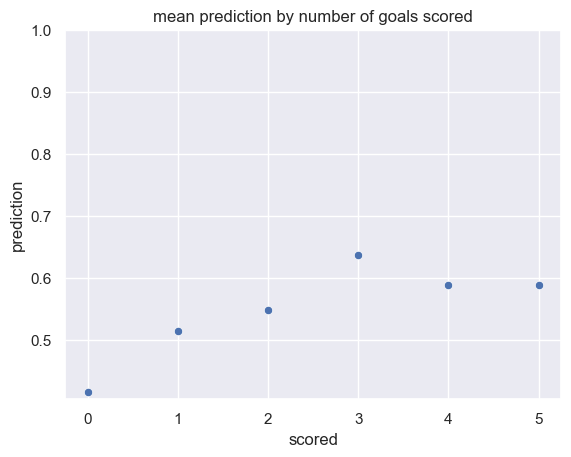

In [59]:
test = data[data['Date'] >= pd.to_datetime('2025-01-01')]
test['prediction'] = model.predict(test)

sns.scatterplot(data=test.groupby('scored', as_index=False).agg({'prediction': 'mean'}), x='scored', y='prediction')
plt.title('mean prediction by number of goals scored')
plt.yticks(np.arange(0.5, 1.01, 0.1));
plt.xticks(range(test['scored'].max() + 1));
test = test.drop(columns='prediction')

### Пуассоновская регрессия.

Попробуем на тех же признаках обучить модель пуассоновской регрессии. Вероятность того, что команда забьет в матче, будем предсказывать как $$\mathbb{P}(y > 0) = 1 - \mathbb{P}(y = 0)$$

In [61]:
class Poisson():
    def __init__(self):
        self.model = None

    def fit(self, formula, train):
        self.model = smf.poisson(formula=formula, data=train).fit(disp=0)
        
    def predict(self, X):
        return 1 - self.model.predict(X, which='prob')[0]

    def predict_for_number(self, X, number):
        return self.model.predict(X, which='prob')[number]

Ставить будем на матчи, для которых предсказанная моделью вероятность того, что команда забьет, больше 0.5 и EV больше чем 1, где

$$ \text{EV} = \mathbb{P}(y = 1) + \text{coef} \cdot \mathbb{P}(y > 1),$$
т.е. матожидание выручки.

Благодаря использованию пуассоновской регрессии данное матожидание мы вполне можем оценить.

In [100]:
formula = 'scored ~ '
for col in train_cols:
    if col in to_drop:
        continue
    if formula[-2:] != '~ ':
        formula += ' + '
    formula += str(col)

train = data[data['Date'] < pd.to_datetime('2025-01-01')]
train0 = train[train['target'] == 0].sample(train[train['target'] == 1].shape[0], replace=True, random_state=94)
train1 = train[train['target'] == 1]
train = pd.concat([train0, train1]).sort_values(by='Date')
pois = Poisson()
pois.fit(formula, train)

print(pois.model.summary())

                          Poisson Regression Results                          
Dep. Variable:                 scored   No. Observations:                 2964
Model:                        Poisson   Df Residuals:                     2952
Method:                           MLE   Df Model:                           11
Date:                Sun, 08 Jun 2025   Pseudo R-squ.:                 0.06078
Time:                        18:04:53   Log-Likelihood:                -3913.2
converged:                       True   LL-Null:                       -4166.5
Covariance Type:            nonrobust   LLR p-value:                1.328e-101
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0313      0.185     -0.169      0.866      -0.394       0.332
avg_scored              0.0487      0.021      2.316      0.021       0.007       0.090
top_club        

In [63]:
def profit_poisson(model, test):
    preds = model.predict(test)

    coefs = test['total_over_1']
    scored = test['scored']
    ev = model.predict_for_number(test, 1) + (1 - model.predict_for_number(test, 1) - model.predict_for_number(test, 0)) * coefs
    to_bet = (ev > 1).astype(int) * (preds > 0.5).astype(int)
    investment = to_bet.sum() * 100
    revenue = ((to_bet * scored > 1).astype(int) * coefs * 100).sum() + ((to_bet * scored == 1).astype(int) * 100).sum()
    
    return revenue - investment, (revenue - investment) / (investment + 1e-12)

In [64]:
res_profit = stats.bootstrap(
    data=(np.arange(len(test)),),
    statistic=lambda idx: profit_poisson(pois, test.iloc[idx])[0],
    confidence_level=0.95,
    method='BCa',
    n_resamples=1000,
    random_state=94
)
print('Profit on test set:', round(profit_poisson(pois, test)[0], 2))
print(f'95% CI for profit: ({round(res_profit.confidence_interval.low, 2)}, {round(res_profit.confidence_interval.high, 2)})')
print()

res_roi = stats.bootstrap(
    data=(np.arange(len(test)),),
    statistic=lambda idx: profit_poisson(pois, test.iloc[idx])[1],
    confidence_level=0.95,
    method='BCa',
    n_resamples=1000,
    random_state=94
)
print('ROI on test set:', round(profit_poisson(pois, test)[1], 2))
print(f'95% CI for ROI: ({round(res_roi.confidence_interval.low, 2)}, {round(res_roi.confidence_interval.high, 2)})')

Profit on test set: 145.0
95% CI for profit: (0.0, 444.0)

ROI on test set: 0.48
95% CI for ROI: (0.0, 0.77)


In [65]:
print('ROC-AUC train:', roc_auc_score(train['target'], pois.predict(train)))
print('ROC-AUC test:', roc_auc_score(test['target'], pois.predict(test)))
print()
print('AUC-PR train:', average_precision_score(train['target'], pois.predict(train)))
print('AUC-PR test:', average_precision_score(test['target'], pois.predict(test)))
print()
tn, fp, fn, tp = confusion_matrix(test['target'], pois.predict(test) > 0.5).ravel()
print('TP test:', tp)
print('FP test:', fp)
print('TN test:', tn)
print('FN test:', fn)

ROC-AUC train: 0.6504737006015506
ROC-AUC test: 0.7586538461538461

AUC-PR train: 0.6433666281834598
AUC-PR test: 0.909221398667986

TP test: 110
FP test: 21
TN test: 19
FN test: 20


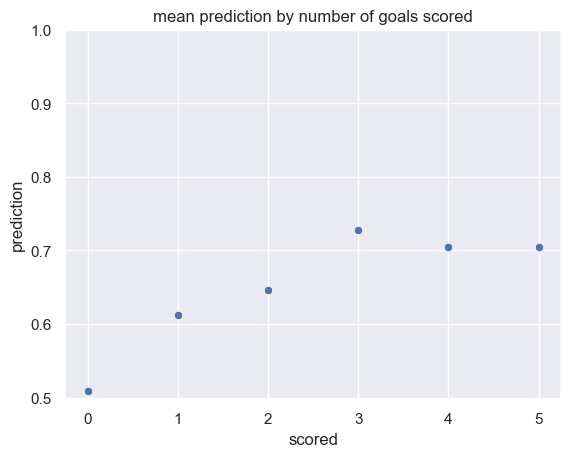

In [66]:
test = data[data['Date'] >= pd.to_datetime('2025-01-01')]
test['prediction'] = pois.predict(test)

sns.scatterplot(data=test.groupby('scored', as_index=False).agg({'prediction': 'mean'}), x='scored', y='prediction')
plt.title('mean prediction by number of goals scored')
plt.yticks(np.arange(0.5, 1.01, 0.1));
plt.xticks(range(test['scored'].max() + 1));
test = test.drop(columns='prediction')

### Голосование по доле объектов.

Сравним модели выше с наивными методами. В данном методе для каждого матча будем предсказывать вероятность положительного класса равной доле объектов положительного класса в обучающей выборке.

In [111]:
class MajorityClassifier():
    def __init__(self):
        self.mean = None

    def fit(self, X_train, y_train):
        self.mean = np.mean(y_train)
        return self

    def predict(self, X):
        return np.array([self.mean for _ in range(X.shape[0])])

train = data[data['Date'] < pd.to_datetime('2025-01-01')]
maj = MajorityClassifier()
maj.fit(train, train['target'])

res_profit = stats.bootstrap(
    data=(np.arange(len(test)),),
    statistic=lambda idx: profit(maj, test.iloc[idx])[0],
    confidence_level=0.95,
    method='BCa',
    n_resamples=1000,
    random_state=94
)
print('Profit on test set:', round(profit(maj, test)[0], 2))
print(f'95% CI for profit: ({round(res_profit.confidence_interval.low, 2)}, {round(res_profit.confidence_interval.high, 2)})')
print()

res_roi = stats.bootstrap(
    data=(np.arange(len(test)),),
    statistic=lambda idx: profit(maj, test.iloc[idx])[1],
    confidence_level=0.95,
    method='BCa',
    n_resamples=1000,
    random_state=94
)
print('ROI on test set:', round(profit(maj, test)[1], 2))
print(f'95% CI for ROI: ({round(res_roi.confidence_interval.low, 2)}, {round(res_roi.confidence_interval.high, 2)})')

Profit on test set: -303.0
95% CI for profit: (-1319.53, 605.28)

ROI on test set: -0.06
95% CI for ROI: (-0.28, 0.14)


### Ставки на основе букмекерских вероятностей.

В данном подходе будем предсказывать вероятность положительного класса равной 1 / коэффициент букмекера, то есть брать "букмекерские" вероятности.

In [114]:
class OddsClassifier():
    def __init__(self):
        self._ = 0

    def predict(self, X):
        return 1 / X['total_over_1'].map(lambda x: 1e12 if x == 0 else x)

odd = OddsClassifier()

res_profit = stats.bootstrap(
    data=(np.arange(len(test)),),
    statistic=lambda idx: profit(odd, test.iloc[idx])[0],
    confidence_level=0.95,
    method='BCa',
    n_resamples=1000,
    random_state=94
)
print('Profit on test set:', round(profit(odd, test)[0], 2))
print(f'95% CI for profit: ({round(res_profit.confidence_interval.low, 2)}, {round(res_profit.confidence_interval.high, 2)})')
print()

res_roi = stats.bootstrap(
    data=(np.arange(len(test)),),
    statistic=lambda idx: profit(odd, test.iloc[idx])[1],
    confidence_level=0.95,
    method='BCa',
    n_resamples=1000,
    random_state=94
)
print('ROI on test set:', round(profit(odd, test)[1], 2))
print(f'95% CI for ROI: ({round(res_roi.confidence_interval.low, 2)}, {round(res_roi.confidence_interval.high, 2)})')

Profit on test set: 340.0
95% CI for profit: (-242.5, 849.44)

ROI on test set: 0.14
95% CI for ROI: (-0.13, 0.34)
